In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [2]:
# Cargamos los datos
df_housing = pd.read_csv("./1_datos/housing.csv")
df_housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [3]:
np.random.seed(42)

# Creamos nuestro atributo categórico para los ingresos
df_housing["income_cat"] = pd.cut(df_housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

# Dividimos los datos en conjunto de entrenamiento y prueba
strat_train_set, strat_test_set = train_test_split(df_housing, test_size=0.2, stratify=df_housing["income_cat"], random_state=42)

# Eliminamos la categoria income_cat de ambos conjuntos porque no la usamos
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Separamos predictores y etiquetas
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

housing_test = strat_test_set.drop("median_house_value", axis=1)
housing_labels_test = strat_test_set["median_house_value"].copy()

# Prepación de los Datos usando transformers

implementar funciones para la transformación de los datos es muy útil.


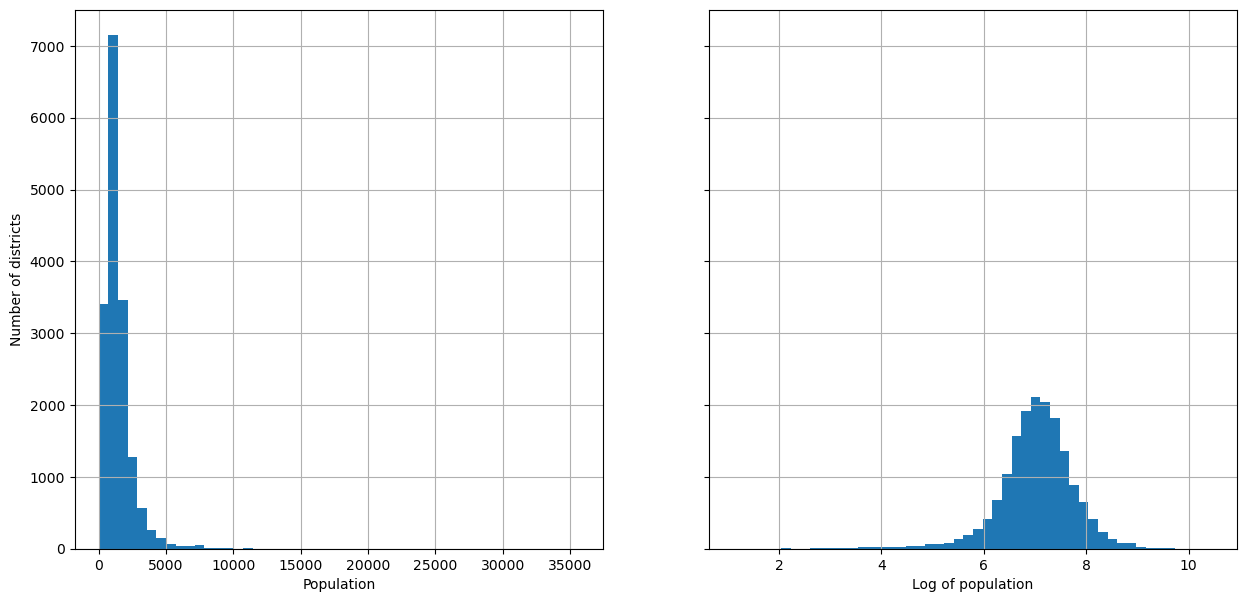

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)

axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")

plt.show()

In [5]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])


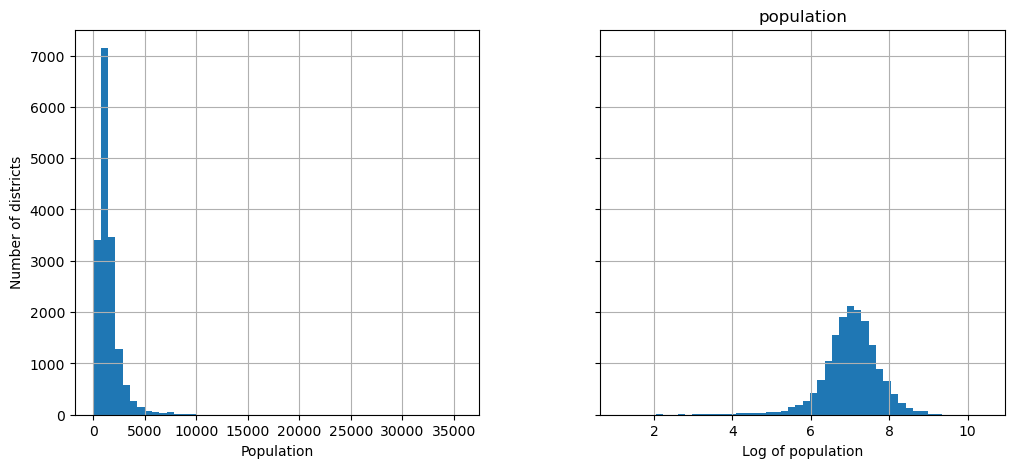

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

housing["population"].hist(ax=axs[0], bins=50)
log_pop.hist(ax=axs[1], bins=50)

axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")

plt.show()

Pero ¿qué sucede si deseas que tu transformador sea entrenable, es decir, que aprenda algunos parámetros en el método `fit()` y los use más tarde en el método `transform()`? Para esto, necesitas escribir una clase personalizada. Scikit-Learn se basa en duck typing, por lo que esta clase no tiene que heredar de ninguna clase base en particular. Lo único que necesita son tres métodos: `fit()` (que debe devolver `self`), `transform()` y `fit_transform()`.

Se puede tener el método `fit_transform()` simplemente agregando `TransformerMixin` como una clase base: la implementación predeterminada simplemente llamará a `fit()` y luego a `transform()`. Si agregas `BaseEstimator` como una clase base, también obtendrás dos métodos adicionales: `get_params()` y `set_params()`. Estos serán útiles para ajustar hiperparámetros.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y es requerido aunque no se usa
        X = check_array(X)  # verifica que X es un array con valores flotantes finitos
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # esta información se guarda en fit
        return self  # siempre debe retornar self!

    def transform(self, X):
        check_is_fitted(self)  # se fija en los atributos entrenados (con _ al final)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

## Pipelines

### Implementemos un pipeline para procesar los datos numéricos

In [7]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")), # los nombres deben ser únicos y no tener __ (dobles guiones bajos)
    ("standardize", StandardScaler()),
])
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

Los componentes deben ser transformers (tener el método `fit_transform()`) excepto el último que debe tener el método `fit()`.

Cuando llamas al método `fit()` del pipeline, este llama secuencialmente a `fit_transform()` en todos los transformers, pasando la salida de cada llamada como parámetro a la siguiente llamada hasta llegar al estimador final, para el cual simplemente llama al método `fit()`.

El pipeline expone los mismos métodos que el estimador final. En este ejemplo, el último estimador es un `StandardScaler`, que es un transformer, por lo que el pipeline también actúa como un transformer. Si llamamos al método `transform()` del pipeline, aplicará secuencialmente todas las transformaciones a los datos.

Si el último estimador fuera un predictor en lugar de un transformador, entonces el pipeline tendrá un método `predict()` en lugar de `transform()`. Llamar a este método aplicaría secuencialmente todas las transformaciones a los datos y pasaría el resultado al método `predict()` del predictor.

In [8]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
1350,-121.95,38.03,5.0,5526.0,NaN,3207.0,1012.0,4.0767,INLAND
4691,-118.37,34.07,50.0,2519.0,NaN,1117.0,516.0,4.3667,<1H OCEAN
9149,-118.50,34.46,17.0,10267.0,NaN,4956.0,1483.0,5.5061,<1H OCEAN
16757,-122.48,37.70,33.0,4492.0,NaN,3477.0,1537.0,3.0546,NEAR OCEAN


In [9]:
housing_num = housing.drop("ocean_proximity", axis=1)

housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.73260236,
         0.55628602, -0.8936472 ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.53361152,
         0.72131799,  1.292168  ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.67467519,
        -0.52440722, -0.52543365],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.86201341,
        -0.86511838, -0.36547546],
       [-1.56080303,  1.2492109 , -1.1653327 , ..., -0.18974707,
         0.01061579,  0.16826095],
       [-1.28105026,  2.02567448, -0.13148926, ..., -0.71232211,
        -0.79857323, -0.390569  ]])

In [10]:
np.isnan(housing_num_prepared).sum()

0

In [11]:
num_pipeline.get_feature_names_out()

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [12]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),   index=housing_num.index)
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752
...,...,...,...,...,...,...,...,...
15174,1.251711,-1.220505,-1.165333,1.890456,1.696862,0.543471,1.341519,0.637374
12661,-0.921368,1.342761,-1.085806,2.468471,2.161816,3.002174,2.451492,-0.557509
19263,-1.570794,1.310018,1.538566,-0.895802,-0.895679,-0.862013,-0.865118,-0.365475
19140,-1.560803,1.249211,-1.165333,0.249005,0.112126,-0.189747,0.010616,0.168261


### Mejor implementar un transformer que aplique las transformaciones necesarias a columnas numéricas y categóricas

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

Otra forma de escribir el transformer anterior sin listar todos los nombres de las columnas y sin nombrar los transformers

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

Ahora si, apliquemos nuestro transformer!!

In [15]:
housing_prepared = preprocessing.fit_transform(housing)

In [16]:
preprocessing.get_feature_names_out()

array(['pipeline-1__longitude', 'pipeline-1__latitude',
       'pipeline-1__housing_median_age', 'pipeline-1__total_rooms',
       'pipeline-1__total_bedrooms', 'pipeline-1__population',
       'pipeline-1__households', 'pipeline-1__median_income',
       'pipeline-2__ocean_proximity_<1H OCEAN',
       'pipeline-2__ocean_proximity_INLAND',
       'pipeline-2__ocean_proximity_ISLAND',
       'pipeline-2__ocean_proximity_NEAR BAY',
       'pipeline-2__ocean_proximity_NEAR OCEAN'], dtype=object)

In [17]:
housing_prepared_df = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)

housing_prepared_df.head()

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.0,1.0,0.0,0.0,0.0
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,0.0,0.0,0.0,0.0,1.0
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,0.0,1.0,0.0,0.0,0.0
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,0.0,0.0,0.0,0.0,1.0
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,1.0,0.0,0.0,0.0,0.0


In [18]:
housing_prepared_df.shape

(16512, 13)

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))


log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())


preprocessing_2 = ColumnTransformer(
    [
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=num_pipeline

    )

In [20]:
housing_prepared_2 = preprocessing_2.fit_transform(housing)

In [21]:
housing_prepared_df_2 = pd.DataFrame(
    housing_prepared_2,
    columns=preprocessing_2.get_feature_names_out(),
    index=housing.index)

housing_prepared_df_2.head()

,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__longitude,remainder__latitude,remainder__housing_median_age
12655,0.873403,0.852032,0.938249,0.797843,-0.998832,0.0,1.0,0.0,0.0,0.0,-0.941350,1.347438,0.027564
15502,0.970407,1.277433,0.796538,0.913214,1.277742,0.0,0.0,0.0,0.0,1.0,1.171782,-1.192440,-1.722018
2908,-0.430559,-0.317644,-0.702499,-0.375177,-0.403837,0.0,1.0,0.0,0.0,0.0,0.267581,-0.125972,1.220460
14053,0.281063,-0.118663,-0.299288,0.277558,-0.947769,0.0,0.0,0.0,0.0,1.0,1.221738,-1.351474,-0.370069
20496,0.583337,0.730040,0.671139,0.528397,0.547635,1.0,0.0,0.0,0.0,0.0,0.437431,-0.635818,-0.131489


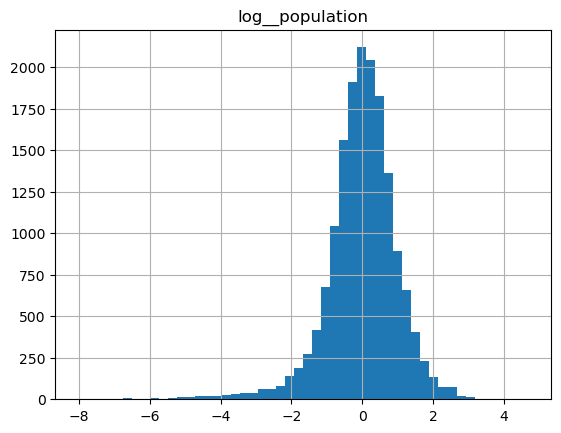

In [22]:
housing_prepared_df_2[['log__population']].hist(bins=50)

plt.show()